# Обработка итоговых результатов

In [1]:
import re
import requests
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, NullLocator
from matplotlib.colors import Normalize
import seaborn as sns
%matplotlib inline

Идентификатор паркрана.

In [2]:
parkrun = 'kuzminki'

Список идентификаторов всех российских паркранов находится в файле `russian_parkruns.csv`.

In [3]:
page_all_results = requests.get(f'https://www.parkrun.ru/{parkrun}/results/eventhistory/', 
                                headers={'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:86.0) Gecko/20100101 Firefox/86.0'})

In [4]:
data = pd.read_html(page_all_results.text)[0]
data = data.drop(columns=data.columns[8:])

In [5]:
data = data.rename(columns={data.columns[0]: 'n', data.columns[1]: 'date',
                           data.columns[2]: 'finishers', data.columns[3]:'volunteers',
                           data.columns[4]: 'men_name', data.columns[5]: 'men_time',
                           data.columns[6]: 'women_name', data.columns[7]: 'women_time'})

In [6]:
pd.set_option('display.max_colwidth', None)

In [7]:
data[data.columns[1]] = data[data.columns[1]].transform(lambda s: re.search(r'\d\d/\d\d/\d{4}', s)[0])
data[data.columns[2]] = data[data.columns[2]].transform(lambda s: s.replace('finishers', ''))
data[data.columns[3]] = data[data.columns[3]].transform(lambda s: s.replace('volunteers', ''))
data[data.columns[4]] = data[data.columns[4]].transform(lambda s: re.sub(r'(\d\d:?){2,3}', '', s))
data[data.columns[6]] = data[data.columns[6]].transform(lambda s: re.sub(r'(\d\d:?){2,3}', '', s))

In [8]:
data

,n,date,finishers,volunteers,men_name,men_time,women_name,women_time
0,206,17/04/2021,176,29,Тихон СМИРНОВ,18:00,Светлана БЕЛАВИНА,21:31
1,205,10/04/2021,161,25,Герман ЖАРОВ,17:03,Екатерина КАРАМЫШЕВА,21:53
2,204,03/04/2021,192,28,Тихон СМИРНОВ,18:51,Светлана БЕЛАВИНА,24:01
3,203,14/03/2020,154,27,Виктор НИКОЛАЕВ,15:46,Наталья СЕЛЕЗНЕВА,20:13
4,202,07/03/2020,176,37,Дмитрий ТИХОНОВ,17:53,Наталья СЕЛЕЗНЕВА,20:15
...,...,...,...,...,...,...,...,...
201,5,16/07/2016,42,12,Дмитрий БОНДАРЬ,18:36,Светлана КАНТОНИСТОВА,22:32
202,4,09/07/2016,46,13,Ринат АВЗЕЛИТДИНОВ,18:05,Ольга АКИМОВА,23:14
203,3,02/07/2016,27,10,Дмитрий БОНДАРЬ,18:52,Янчик КРЖИЖАНОВСКАЯ,23:24
204,2,25/06/2016,40,15,Алексей КУХАРЕНКО,18:28,Olga LAZAREVA,22:15


In [9]:
data['men_time_m'] = data['men_time'].transform(lambda time: sum(x * int(t) for x, t in zip([1/60, 1, 60], time.split(':')[::-1])))
data['women_time_m'] = data['women_time'].transform(lambda time: sum(x * int(t) for x, t in zip([1/60, 1, 60], time.split(':')[::-1])))

In [10]:
# data[data.columns[5]] = ('00:' + data[data.columns[5]]).apply(pd.to_timedelta)
# data[data.columns[7]] = ('00:' + data[data.columns[7]]).apply(pd.to_timedelta)

In [11]:
def min_to_mmss(m: float) -> str:
    mins = int(m)
    return f'{mins}:{int((m - mins) * 60)}'

In [12]:
number_parkruns = len(data)

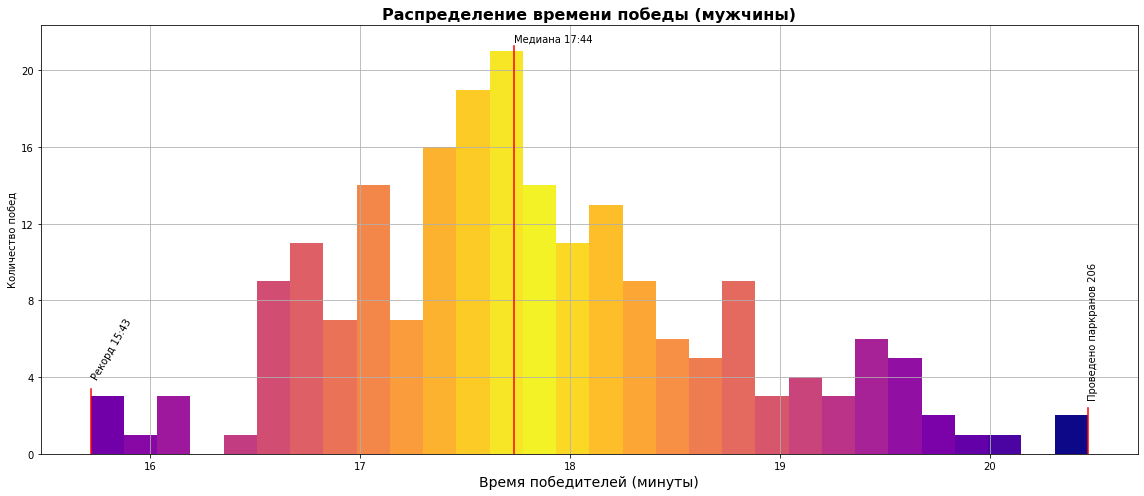

In [13]:
plt.figure(figsize=(16, 7))
ax = data['men_time_m'].hist(bins=30)
ax.yaxis.set_major_locator(MultipleLocator(4))
ptchs = ax.patches
med = data['men_time_m'].median()
norm = Normalize(min(2*med-ptchs[-1].get_x(), ptchs[0].get_x()), med)

for ptch in ptchs:
    ptch_x = ptch.get_x()
    color = plt.cm.plasma(norm(med-abs(ptch_x-med)))
    ptch.set_facecolor(color)
    if ptch_x <= med:
        m_height = ptch.get_height() + 0.3
    

ax.set_xlabel("Время победителей (минуты)", size=14)
ax.set_ylabel("Количество побед")

ax.annotate(f'Медиана {min_to_mmss(med)}', (med, m_height+0.2))
plt.plot([med,med],[0,m_height], 'r')

ldr_time = ptchs[0].get_x()
ldr_y_mark = ptchs[0].get_height() + 0.4
ax.annotate(f'Рекорд {min_to_mmss(ldr_time)}', (ldr_time, ldr_y_mark+0.5), rotation=60)
plt.plot([ldr_time,ldr_time],[0,ldr_y_mark], 'r')

lst_time = ptchs[-1].get_x() + ptchs[-1].get_width()
lst_y_mark = ptchs[-1].get_height() + 0.4
ax.annotate(f'Проведено паркранов {number_parkruns}', (lst_time, lst_y_mark+0.5), rotation=90)
plt.plot([lst_time,lst_time],[0,lst_y_mark], 'r')
plt.title('Распределение времени победы (мужчины)', size=16, fontweight='bold')

plt.tight_layout()
# plt.savefig('results.png')

## Статистика по мужчинам

### Топ10 мужчин по числу побед

In [14]:
data['men_name'].value_counts().head(10)

Герман ЖАРОВ          45
Юрий ВОЛОДИН          38
Платон КИСЕЛЕВ        14
Дмитрий БОНДАРЬ       13
Александр ТАГАНЦЕВ    12
Дмитрий ТИХОНОВ        7
Максим ПЕТРИЩЕВ        7
Сергей СИЛИН           7
Владимир ИВАНОВ        6
Виктор НИКОЛАЕВ        5
Name: men_name, dtype: int64

### Среднее время мужчины-победителя

Рассчитывается среднее время на всех паркранах, на которых была одержана победа.

Можно видеть чего примерно ждать от того или иного участника.

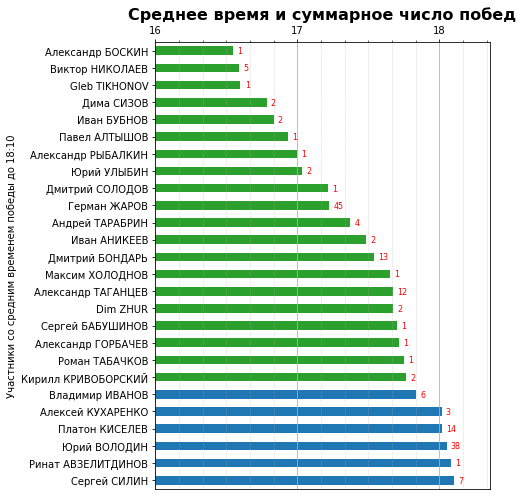

In [15]:
leaders_men_avr_time = data.groupby('men_name')['men_time_m'].mean().sort_values(ascending=False)
mm = data['men_time_m'].mean() * 1.02
plt.figure(figsize=(7,7))
plt.xlim([int(leaders_men_avr_time[-1]), 1.01 * mm])
ax = leaders_men_avr_time[leaders_men_avr_time < mm].plot(kind = 'barh', grid=True)
for ptch, tick in zip(ax.patches, ax.yaxis.get_major_ticks()):
    c = '#2ca02c' if ptch.get_width() < mm / 1.02 else '#1f77b4'
    ptch.set_facecolor(c)
    ax.annotate(
        str(data['men_name'].value_counts()[tick.label.get_text()]), 
        (ptch.get_width()+0.03, ptch.get_y()+ptch.get_height()/5), size=8, color='r'
        )
ax.minorticks_on()
ax.grid(b=False, which='major', axis='y')
ax.grid(which='minor', axis='x', lw=0.5, ls=':')
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(1/6))
ax.xaxis.tick_top()
ax.yaxis.set_minor_locator(NullLocator())
ax.set_ylabel(f'Участники со средним временем победы до {min_to_mmss(mm)}')
plt.title('Среднее время и суммарное число побед', size=16, fontweight='bold')
plt.tight_layout()

### Среднее время победителя (мужчины)

In [16]:
mean_men_time = data['men_time_m'].mean()
print(min_to_mmss(mean_men_time))

17:49


### Топ10 мужских результатов

In [17]:
data.sort_values(by=['men_time_m']).drop(data.iloc[:,[2,3,6,7,8,9]], axis=1).reset_index(drop=True).head(10)

,n,date,men_name,men_time
0,107,09/06/2018,Иван БУБНОВ,15:43
1,203,14/03/2020,Виктор НИКОЛАЕВ,15:46
2,54,17/06/2017,Виктор НИКОЛАЕВ,15:51
3,100,21/04/2018,Виктор НИКОЛАЕВ,15:59
4,162,15/06/2019,Герман ЖАРОВ,16:07
5,179,12/10/2019,Герман ЖАРОВ,16:09
6,67,16/09/2017,Дима СИЗОВ,16:10
7,19,22/10/2016,Герман ЖАРОВ,16:24
8,172,24/08/2019,Герман ЖАРОВ,16:31
9,130,17/11/2018,Александр БОСКИН,16:33


## Статистика по женщинам

### Топ10 женщин по числу побед

In [18]:
data['women_name'].value_counts().head(10)

Светлана БЕЛАВИНА        19
Светлана КИРЕЕВА         15
Ирина ЕРМАКОВА           10
Диана ГАБИТОВА           10
Янчик КРЖИЖАНОВСКАЯ      10
Алсу ШАГИЕВА              9
Марина ХЛОПКОВА           7
Кристина ЖУРАВЛЕВА        6
Ольга ХМЕЛЕВСКАЯ          6
Светлана КАНТОНИСТОВА     4
Name: women_name, dtype: int64

### Среднее время победителя (женщины)

In [19]:
print(min_to_mmss(data['women_time_m'].mean()))

22:59


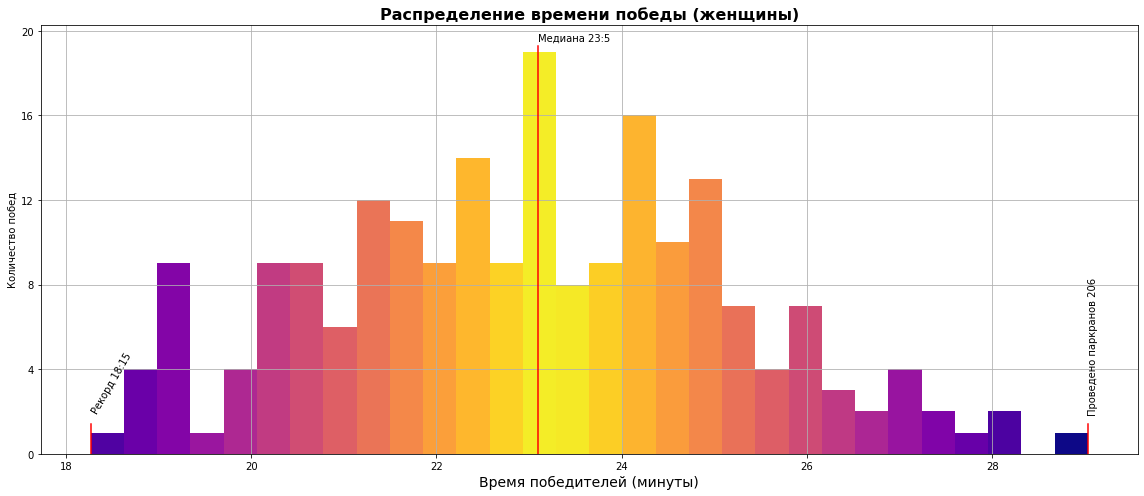

In [20]:
plt.figure(figsize=(16, 7))
ax = data['women_time_m'].hist(bins=30)
ax.yaxis.set_major_locator(MultipleLocator(4))
ptchs = ax.patches
med = data['women_time_m'].median()
norm = Normalize(min(2*med-ptchs[-1].get_x(), ptchs[0].get_x()), med)

for ptch in ptchs:
    ptch_x = ptch.get_x()
    color = plt.cm.plasma(norm(med-abs(ptch_x-med)))
    ptch.set_facecolor(color)
    if ptch_x <= med:
        m_height = ptch.get_height() + 0.3
    

ax.set_xlabel("Время победителей (минуты)", size=14)
ax.set_ylabel("Количество побед")

ax.annotate(f'Медиана {min_to_mmss(med)}', (med, m_height+0.2))
plt.plot([med,med],[0,m_height], 'r')

ldr_time = ptchs[0].get_x()
ldr_y_mark = ptchs[0].get_height() + 0.4
ax.annotate(f'Рекорд {min_to_mmss(ldr_time)}', (ldr_time, ldr_y_mark+0.5), rotation=60)
plt.plot([ldr_time, ldr_time], [0, ldr_y_mark], 'r')

lst_time = ptchs[-1].get_x() + ptchs[-1].get_width()
lst_y_mark = ptchs[-1].get_height() + 0.4
ax.annotate(f'Проведено паркранов {number_parkruns}', (lst_time, lst_y_mark+0.5), rotation=90)
plt.plot([lst_time, lst_time], [0, lst_y_mark], 'r')
plt.title('Распределение времени победы (женщины)', size=16, fontweight='bold')

plt.tight_layout()
# plt.savefig('results.png')

### Топ10 женских результатов

In [21]:
data.sort_values(by=['women_time_m']).drop(data.iloc[:,[2,3,4,5,8,9]], axis=1).reset_index(drop=True).head(10)

,n,date,women_name,women_time
0,68,23/09/2017,Тома СИЗОВА,18:16
1,67,16/09/2017,Тома СИЗОВА,18:44
2,50,20/05/2017,Алсу ШАГИЕВА,18:47
3,14,17/09/2016,Алсу ШАГИЕВА,18:53
4,1,18/06/2016,Алсу ШАГИЕВА,18:57
5,48,06/05/2017,Алсу ШАГИЕВА,19:02
6,72,21/10/2017,Светлана КИРЕЕВА,19:08
7,20,29/10/2016,Nina ZARINA,19:08
8,175,14/09/2019,Екатерина БАШМАКОВА,19:13
9,100,21/04/2018,Алсу ШАГИЕВА,19:13


Среди женщин нет явных постоянных лидеров (участниц, которые регулярно выигрывают).
А сильный разброс времени победительницы говорит также об очень слабой конкуренции и соревновательности.

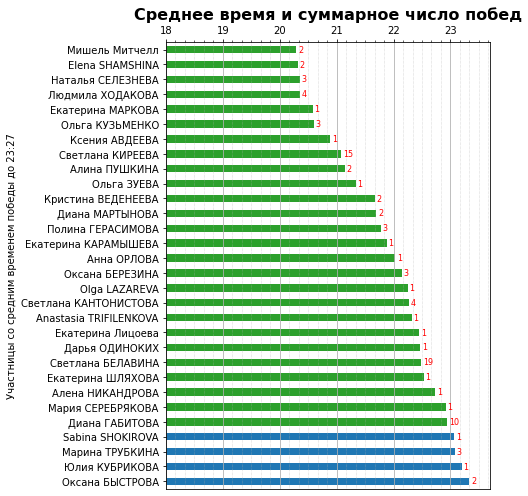

In [22]:
leaders_avr_time = data.groupby('women_name')['women_time_m'].mean().sort_values(ascending=False)
mm = data['women_time_m'].mean() * 1.02
plt.figure(figsize=(7,7))
plt.xlim([int(leaders_avr_time[-1]), 1.01 * mm])
ax = leaders_avr_time[leaders_avr_time < mm][:30].plot(kind = 'barh', grid=True)
for ptch, tick in zip(ax.patches, ax.yaxis.get_major_ticks()):
    c = '#2ca02c' if ptch.get_width() < mm / 1.02 else '#1f77b4'
    ptch.set_facecolor(c)
    ax.annotate(
        str(data['women_name'].value_counts()[tick.label.get_text()]), 
        (ptch.get_width()+0.03, ptch.get_y()+ptch.get_height()/5), size=8, color='r'
        )
ax.minorticks_on()
ax.grid(b=False, which='major', axis='y')
ax.grid(which='minor', axis='x', lw=0.5, ls=':')
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(1/6))
ax.xaxis.tick_top()
ax.yaxis.set_minor_locator(NullLocator())
ax.set_ylabel(f'Участницы со средним временем победы до {min_to_mmss(mm)}')
plt.title('Среднее время и суммарное число побед', size=16, fontweight='bold')
plt.tight_layout()